In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import scipy.stats as stats
import pingouin as pg
from  matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
import matplotlib
from mpl_toolkits.axes_grid1 import AxesGrid

In [2]:
df = pd.read_csv('../../results/results.csv')

flags = df['flag'].unique()
progs = df['program'].unique()

print(f'total program-flag combinations: {(len(flags)) * len(progs)}')

pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

total program-flag combinations: 891


In [3]:
# Remove outliers from the initial data

col = 'pkg_energy'
total_outliers = 0

for prog in progs:
    for flag in flags:
        data = df[(df['program'] == prog) & (df['flag'] == flag)]
        q75, q25 = np.percentile(data.loc[:,col],[75,25])
        intr_qr = q75 - q25

        max = q75 + (1.5 * intr_qr)
        min = q25 - (1.5 * intr_qr)

        data.loc[data[col] < min,col] = np.nan
        data.loc[data[col] > max,col] = np.nan

        outliers_count = data[col].isnull().sum()
        total_outliers += outliers_count

        # remove outliers
        df[(df['program'] == prog) & (df['flag'] == flag)] = data.dropna(axis=0)

print(f'Removed a total of {total_outliers} outliers')

/home/bernas/.local/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.1, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


Removed a total of 443 outliers


In [4]:
# Perform Shapiro-Wilks test for each program-flag combination
# to check if the data follows a normal distribution
norm_df = []

for prog in progs:
    for flag in flags:
        w, pvalue = stats.shapiro(df[(df['flag'] == flag) & (df['program'] == prog)]['pkg_energy'])
        norm_df.append([prog, flag, w, pvalue, pvalue >= 0.05])

norm_df = pd.DataFrame(norm_df, columns=['prog', 'flag', 'sw_w', 'sw_p', 'is_normal'])
norm_count = len(norm_df[norm_df['is_normal'] == True])

print(f'prog-flag combinations that follow a normal distribution: {norm_count}')
# display(norm_df)

prog-flag combinations that follow a normal distribution: 850


In [5]:
# Check Homogeneity of variances

# For data drawn from NORMAL distributions
# Perform Bartlett's test
norm_progs = norm_df[norm_df['is_normal'] == True]['prog'].unique()

homo_df = []
for prog in norm_progs:
    norm_flags = norm_df[(norm_df['prog'] == prog) & (norm_df['is_normal'] == True)]['flag'].values.tolist()

    if (len(norm_flags) <= 1 or '-O0' not in norm_flags): continue

    norm_flags.remove('-O0')

    for flag in norm_flags:
        data = [df[(df['flag'] == f) & (df['program'] == prog)]['pkg_energy'] for f in [flag, '-O0']]
        w, pvalue = stats.bartlett(*data)
        homo_df.append(['bartlett', prog, flag, w, pvalue, pvalue >= 0.12])

# For data that is not drawn from NORMAL distributions
# Perform Lavene's test
non_norm_progs = norm_df[norm_df['is_normal'] == False]['prog'].unique()
for prog in non_norm_progs:
    non_norm_flags = norm_df[(norm_df['prog'] == prog) & (norm_df['is_normal'] == False)]['flag'].values.tolist()

    if (len(non_norm_flags) <= 1 or '-O0' not in non_norm_flags): continue
    non_norm_flags.remove('-O0')

    for flag in non_norm_flags:
        data = [df[(df['flag'] == f) & (df['program'] == prog)]['pkg_energy'] for f in [flag, '-O0']]
        w, pvalue = stats.levene(*data)
        homo_df.append(['levene', prog, flag, w, pvalue, pvalue > 0.05])

homo_df = pd.DataFrame(homo_df, columns=['test','prog', 'flag', 'w', 'p', 'eq_var'])
print(homo_df)

homo_norm_count = len(homo_df[(homo_df['eq_var'] == True) & (homo_df['test'] == 'bartlett')])
homo_non_norm_count = len(homo_df[(homo_df['eq_var'] == True) & (homo_df['test'] == 'levene')])

print(f'\nnormal prog-flag combinations with homogeneity of variances: {homo_norm_count}')
print(f'\nnon-normal prog-flag combinations with homogeneity of variances: {homo_non_norm_count}')

         test            prog                         flag        w       p  \
0    bartlett       cacheprof                 -fcase-merge  3.81817 0.05070   
1    bartlett       cacheprof               -fcase-folding  1.30887 0.25260   
2    bartlett       cacheprof                 -fcall-arity  0.60978 0.43487   
3    bartlett       cacheprof              -fexitification  3.31004 0.06886   
4    bartlett       cacheprof     -fcmm-elim-common-blocks  1.13096 0.28757   
5    bartlett       cacheprof                   -fcmm-sink  0.31071 0.57724   
6    bartlett       cacheprof                   -fcpr-anal  0.25591 0.61294   
7    bartlett       cacheprof                        -fcse  6.19582 0.01281   
8    bartlett       cacheprof                    -fstg-cse  6.70447 0.00962   
9    bartlett       cacheprof            -fdmd-tx-dict-sel  0.27915 0.59726   
10   bartlett       cacheprof           -fdo-eta-reduction  2.18350 0.13950   
11   bartlett       cacheprof    -fdo-lambda-eta-exp

In [6]:
values = []

for prog in progs:
    data = [df[(df['flag'] == flag) & (df['program'] == prog)]['pkg_energy'] for flag in flags]
    fvalue, pvalue = stats.f_oneway(*data)
    values.append([prog, fvalue, pvalue, pvalue < 0.05])

values_df = pd.DataFrame(values, columns=['Program', 'F Value', 'P Value', 'p < 0.05'])
print(values_df)

           Program      F Value  P Value  p < 0.05
0        cacheprof      6.21512  0.00000      True
1      constraints     18.21168  0.00000      True
2             hash     44.01117  0.00000      True
3       bernouilli     15.11574  0.00000      True
4           exp3_8      6.64025  0.00000      True
5      gen_regexps     55.88943  0.00000      True
6        integrate    137.52717  0.00000      True
7             anna      9.89890  0.00000      True
8   real_cacheprof     13.05432  0.00000      True
9        compress2     15.12639  0.00000      True
10    binary-trees     23.31498  0.00000      True
11           fasta    751.96187  0.00000      True
12    k-nucleotide    194.97674  0.00000      True
13        pidigits     15.35568  0.00000      True
14     callback001     13.07796  0.00000      True
15     callback002      1.76068  0.01541      True
16            chan      5.83176  0.00000      True
17            ansi     15.10279  0.00000      True
18            atom      6.54581

In [7]:
# ANOVA only considering the program-flag combinations that respect all assumptions

values = []
for prog in homo_df[homo_df['eq_var'] == True]['prog'].unique():
    p_flags = homo_df[homo_df['prog'] == prog]['flag']

    for flag in p_flags:
        data = [df[(df['flag'] == f) & (df['program'] == prog)]['pkg_energy'] for f in [flag, '-O0']]
        fvalue, pvalue = stats.f_oneway(*data)
        values.append([prog, flag, fvalue, pvalue, pvalue < 0.05])

values_df = pd.DataFrame(values, columns=['Program', 'Flag', 'F Value', 'P Value', 'p < 0.05'])

count_val = len(values_df[values_df['p < 0.05'] == True])
total_comb = (len(flags) - 1) * len(progs)
print(f'prog-flag combinations that are comparable: {count_val}/{total_comb} ({count_val/total_comb * 100:.0f} %)\n')
print(f'non-comparable {len(values_df[values_df["p < 0.05"] == False])}')

flags_count = []
for flag in flags:
    c = len(values_df[(values_df['Flag'] == flag) & (values_df['p < 0.05'] == True)])
    p = values_df[(values_df['Flag'] == flag) & (values_df['p < 0.05'] == True)]['Program'].unique()

    nd = len(values_df[(values_df['Flag'] == flag) & (values_df['p < 0.05'] == False)])
    nd_p = values_df[(values_df['Flag'] == flag) & (values_df['p < 0.05'] == False)]['Program'].unique()
    
    na = len(progs) - c - nd
    na_p = list(filter(lambda x: x not in [*p, *nd_p], progs))

    flags_count.append([flag, c, p, nd, nd_p, na, na_p])
flags_df = pd.DataFrame(flags_count, columns=['Flag', 'Count', 'Programs', 'NotDiff', 'NotDiffProgs', 'NoAssu', 'NoAssuProgs'])
flags_df = flags_df.drop(flags_df.index[0])
display(flags_df)
# print(flags_df.to_latex(index=False))
# print(flags_df[['Flag', 'Count', 'NotDiff', 'NoAssu']].to_latex(index=False))

print(np.sum(flags_df['Count']))
print(np.sum(flags_df['NotDiff']))
print(np.sum(flags_df['NoAssu']))
    

prog-flag combinations that are comparable: 374/858 (44 %)

non-comparable 340


,Flag,Count,Programs,NotDiff,NotDiffProgs,NoAssu,NoAssuProgs
1,-fcase-merge,8,"[hash, gen_regexps, integrate, fasta, pidigits, ansi, awards, coins]",20,"[cacheprof, constraints, bernouilli, anna, real_cacheprof, compress2, binary-trees, callback001, callback002, chan, atom, gg, parser, cryptarithm1, life, power, treejoin, queens, parfib, blackscholes]",5,"[exp3_8, k-nucleotide, banner, fluid, clausify]"
2,-fcase-folding,9,"[gen_regexps, compress2, binary-trees, fasta, pidigits, ansi, awards, parser, life]",18,"[cacheprof, constraints, hash, bernouilli, integrate, anna, real_cacheprof, callback001, callback002, chan, atom, cryptarithm1, power, treejoin, queens, parfib, blackscholes, coins]",6,"[exp3_8, k-nucleotide, banner, gg, fluid, clausify]"
3,-fcall-arity,9,"[integrate, anna, fasta, pidigits, callback001, awards, parser, power, coins]",19,"[cacheprof, constraints, hash, bernouilli, gen_regexps, real_cacheprof, compress2, binary-trees, callback002, chan, ansi, atom, gg, cryptarithm1, life, treejoin, queens, parfib, blackscholes]",5,"[exp3_8, k-nucleotide, banner, fluid, clausify]"
4,-fexitification,13,"[cacheprof, gen_regexps, real_cacheprof, compress2, binary-trees, fasta, pidigits, callback001, ansi, awards, gg, life, coins]",14,"[hash, bernouilli, integrate, anna, callback002, chan, atom, parser, cryptarithm1, power, treejoin, queens, parfib, blackscholes]",6,"[constraints, exp3_8, k-nucleotide, banner, fluid, clausify]"
5,-fcmm-elim-common-blocks,16,"[constraints, hash, gen_regexps, integrate, binary-trees, fasta, ansi, awards, gg, parser, life, power, treejoin, parfib, blackscholes, coins]",11,"[cacheprof, bernouilli, anna, real_cacheprof, compress2, pidigits, callback002, chan, atom, cryptarithm1, queens]",6,"[exp3_8, k-nucleotide, callback001, banner, fluid, clausify]"
6,-fcmm-sink,21,"[cacheprof, hash, bernouilli, integrate, compress2, binary-trees, fasta, pidigits, callback001, callback002, chan, ansi, atom, awards, parser, cryptarithm1, life, queens, parfib, blackscholes, coins]",5,"[constraints, anna, real_cacheprof, gg, treejoin]",7,"[exp3_8, gen_regexps, k-nucleotide, banner, fluid, clausify, power]"
7,-fcpr-anal,13,"[cacheprof, constraints, gen_regexps, fasta, callback001, ansi, atom, awards, gg, parser, life, parfib, coins]",16,"[hash, bernouilli, integrate, anna, real_cacheprof, compress2, binary-trees, pidigits, callback002, chan, cryptarithm1, power, treejoin, queens, blackscholes, clausify]",4,"[exp3_8, k-nucleotide, banner, fluid]"
8,-fcse,16,"[bernouilli, gen_regexps, integrate, anna, real_cacheprof, binary-trees, fasta, callback001, ansi, awards, gg, parser, power, queens, parfib, coins]",12,"[cacheprof, constraints, hash, compress2, pidigits, callback002, chan, atom, cryptarithm1, life, treejoin, blackscholes]",5,"[exp3_8, k-nucleotide, banner, fluid, clausify]"
9,-fstg-cse,20,"[constraints, bernouilli, gen_regexps, integrate, compress2, binary-trees, fasta, pidigits, callback001, callback002, ansi, atom, awards, gg, parser, cryptarithm1, life, power, treejoin, blackscholes]",7,"[cacheprof, hash, anna, real_cacheprof, chan, parfib, coins]",6,"[exp3_8, k-nucleotide, banner, fluid, clausify, queens]"
10,-fdmd-tx-dict-sel,14,"[cacheprof, hash, gen_regexps, integrate, compress2, binary-trees, fasta, callback001, ansi, atom, awards, gg, cryptarithm1, coins]",15,"[constraints, bernouilli, anna, real_cacheprof, pidigits, callback002, chan, parser, life, power, treejoin, queens, parfib, blackscholes, clausify]",4,"[exp3_8, k-nucleotide, banner, fluid]"


374
340
144


In [8]:
# Calculate effect size
# Perform Hedge's g (n < 20)

# effsize > 0 ==> optimized program consumed more energy
# effsize < 0 ==> optimized program consumed less energy

# effsize = 0.2 ==> small
# effsize = 0.5 ==> medium
# effsize = 0.8 ==> large

pd.set_option('display.float_format', lambda x: '%.5f' % x)

eff_df = []
for _, row in flags_df.iterrows():
    flag = row['Flag']
    for prog in row['Programs']:
        effsize = pg.compute_effsize(
            df[(df['flag'] == flag) & (df['program'] == prog)]['pkg_energy'],
            df[(df['flag'] == '-O0') & (df['program'] == prog)]['pkg_energy'],
            eftype='hedges'
        )
        eff_df.append([flag, prog, effsize])
eff_df = pd.DataFrame(eff_df, columns=['flag', 'prog', 'effsize']) 
# display(eff_df)
print(eff_df.to_latex(index=False))

# print(np.min(np.abs(eff_df['effsize'])))

# print(eff_df[eff_df['prog'] == 'fasta'].to_latex(index=False))

\begin{tabular}{llr}
\toprule
                       flag &           prog &   effsize \\
\midrule
               -fcase-merge &           hash &  -1.14379 \\
               -fcase-merge &    gen\_regexps &   1.00298 \\
               -fcase-merge &      integrate &   1.09567 \\
               -fcase-merge &          fasta &  47.07912 \\
               -fcase-merge &       pidigits &   1.62089 \\
               -fcase-merge &           ansi &   1.00655 \\
               -fcase-merge &         awards &   9.76595 \\
               -fcase-merge &          coins &  -1.19409 \\
             -fcase-folding &    gen\_regexps &  -1.14526 \\
             -fcase-folding &      compress2 &  -1.24174 \\
             -fcase-folding &   binary-trees &  -0.97394 \\
             -fcase-folding &          fasta &  20.82546 \\
             -fcase-folding &       pidigits &   1.42464 \\
             -fcase-folding &           ansi &   1.63178 \\
             -fcase-folding &         awards &  11.94969 \\

/tmp/ipykernel_148426/3089969125.py:25: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(eff_df.to_latex(index=False))


-14.926166946441553
85.11834412949199


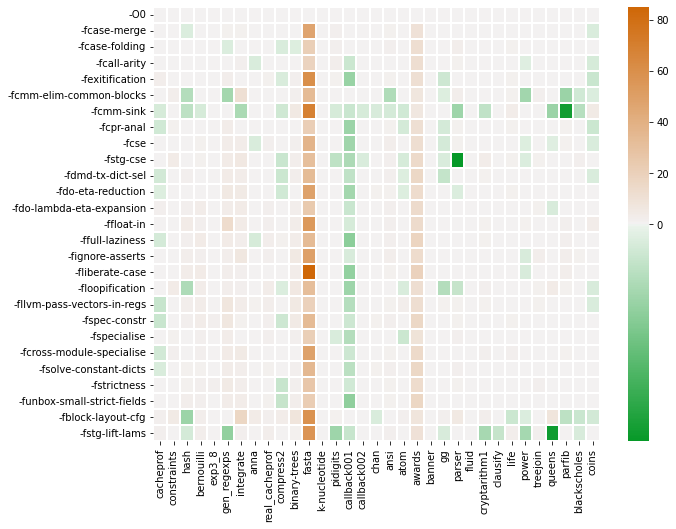

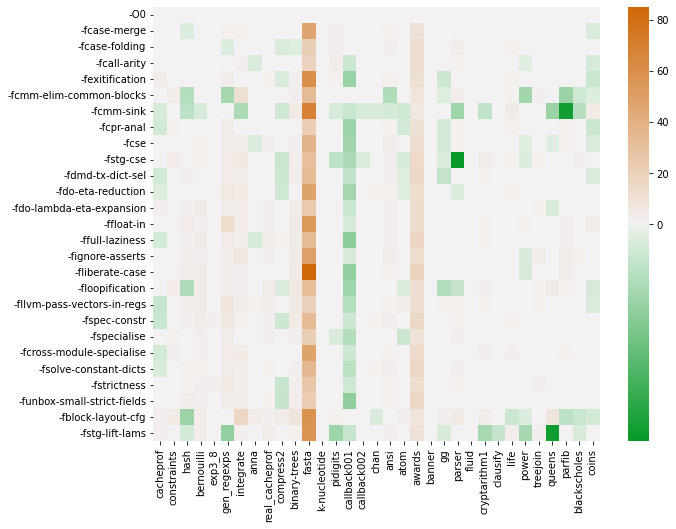

In [9]:
data = []
for flag in flags:
    row = []
    for prog in progs:
        # if prog == 'fasta':
            # row.append(0)
            # continue
        val = eff_df[(eff_df['flag'] == flag) & (eff_df['prog'] == prog)]['effsize'].values

        if (len(val) == 0):
            val = [0]

        row.append(val[0])
        # print(eff_df[(eff_df['flag'] == flag) & (eff_df['prog'] == prog)]['effsize'].values)
        # row.append(eff_df[(eff_df['flag'] == flag) & (eff_df['prog'] == prog)]['effsize'])
    data.append(row)

# print(data)
vmin = eff_df['effsize'].min()
vmax = eff_df['effsize'].max()

print(vmin)
print(vmax)

cmap = LinearSegmentedColormap.from_list('',["green", "white", "red"], N=256)
cmap2  = sns.diverging_palette(
    h_neg=130, 
    h_pos=30, 
    s=99, 
    l=55, 
    sep=1, 
    as_cmap=True)
divnorm = matplotlib.colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data, 
    xticklabels=progs, yticklabels=flags,
    cmap=cmap2,
    norm=divnorm,
    linewidths=2
)
plt.show()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data, 
    xticklabels=progs, yticklabels=flags,
    cmap=cmap2,
    norm=divnorm,
)
plt.show()


In [10]:
# generate latex table for effect size
lines = list(eff_df.to_latex(index=False).split("\n"))[4:-3]
n = len(lines)
# lines = [str(i) for i in range(0, 10)]

data = []
for i in range(0, n//2 if n%2 == 0 else n//2 + 1):
    l = " & & \\\\"

    if n%2 == 0:
        l = lines[n//2 + i]
    elif i + n//2 + 1 != n:
        l = lines[n//2 + i + 1]

    data.append(f'{lines[i][:-4]} & & {l}')

for l in data:
    print(l)

               -fcase-merge &           hash &  -1.1437 & &             -ffull-laziness &          fasta &  33.66177 \\
               -fcase-merge &    gen\_regexps &   1.0029 & &             -ffull-laziness &    callback001 &  -6.23866 \\
               -fcase-merge &      integrate &   1.0956 & &             -ffull-laziness &           ansi &   1.94529 \\
               -fcase-merge &          fasta &  47.0791 & &             -ffull-laziness &         awards &  17.34258 \\
               -fcase-merge &       pidigits &   1.6208 & &             -ffull-laziness &   cryptarithm1 &   1.04604 \\
               -fcase-merge &           ansi &   1.0065 & &             -ffull-laziness &         parfib &   1.54083 \\
               -fcase-merge &         awards &   9.7659 & &            -fignore-asserts &           hash &   2.48827 \\
               -fcase-merge &          coins &  -1.1940 & &            -fignore-asserts &     bernouilli &   1.67802 \\
             -fcase-folding &    gen\_r

/tmp/ipykernel_148426/4062300238.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  lines = list(eff_df.to_latex(index=False).split("\n"))[4:-3]


,flag,# e > 0,# e = 0,# e < 0,% > 0,% = 0,% < 0
0,-fcase-merge,6,20,2,21.43,71.43,7.14
1,-fcase-folding,6,18,3,22.22,66.67,11.11
2,-fcall-arity,5,19,4,17.86,67.86,14.29
3,-fexitification,9,14,4,33.33,51.85,14.81
4,-fcmm-elim-common-blocks,8,11,8,29.63,40.74,29.63
5,-fcmm-sink,5,5,16,19.23,19.23,61.54
6,-fcpr-anal,8,16,5,27.59,55.17,17.24
7,-fcse,10,12,6,35.71,42.86,21.43
8,-fstg-cse,12,7,8,44.44,25.93,29.63
9,-fdmd-tx-dict-sel,8,15,6,27.59,51.72,20.69


# e > 0: 256
# e < 0: 118
# flags pos > neg: 23
% > 0: 36.02509152111274
% = 0: 47.355873274971415
% < 0: 16.61903520391584
100.0


<AxesSubplot:xlabel='% < 0', ylabel='Count'>

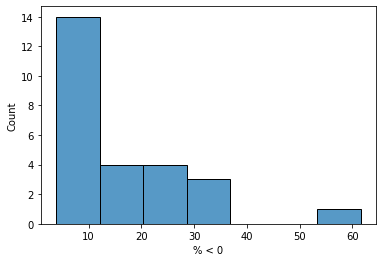

In [11]:
m_eff_df = []
for flag in eff_df['flag'].unique():
    pos = len(eff_df[(eff_df['flag'] == flag) & (eff_df['effsize'] > 0)])
    neg = len(eff_df[(eff_df['flag'] == flag) & (eff_df['effsize'] < 0)])
    nul = len(values_df[(values_df['Flag'] == flag) & (values_df['p < 0.05'] == False)])

    t = pos + neg + nul


    p_pos = eff_df[(eff_df['flag'] == flag) & (eff_df['effsize'] > 0)]['prog'].unique()
    p_neg = eff_df[(eff_df['flag'] == flag) & (eff_df['effsize'] < 0)]['prog'].unique()
    # m_eff_df.append([flag, pos, neg, neg/(pos+neg), p_pos, p_neg])
    m_eff_df.append([flag, pos, nul, neg, pos * 100 / t, nul * 100/ t, neg * 100/ t])
# m_eff_df = pd.DataFrame(m_eff_df, columns=['flag', 'pos', 'neg', '% neg', 'pos progs', 'neg progs'])
m_eff_df = pd.DataFrame(m_eff_df, columns=['flag', '# e > 0', '# e = 0', '# e < 0', '% > 0', '% = 0', '% < 0'])
# print(m_eff_df.to_latex(index=False)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
display(m_eff_df)
# print(m_eff_df.to_latex(index=False))

avg1 = np.average(m_eff_df['% > 0'])
avg2 = np.average(m_eff_df['% = 0'])
avg3 = np.average(m_eff_df['% < 0'])

print(f'# e > 0: {np.sum(m_eff_df["# e > 0"])}')
print(f'# e < 0: {np.sum(m_eff_df["# e < 0"])}')

print(f'# flags pos > neg: {len(m_eff_df[(m_eff_df["# e > 0"] > m_eff_df["# e < 0"])])}')

print(f'% > 0: {avg1}')
print(f'% = 0: {avg2}')
print(f'% < 0: {avg3}')
print(avg1 + avg2 + avg3)

sns.histplot(m_eff_df['% < 0'])

In [12]:
prog_eff_df = []
for prog in eff_df['prog'].unique():
    pos = len(eff_df[(eff_df['prog'] == prog) & (eff_df['effsize'] > 0)])
    neg = len(eff_df[(eff_df['prog'] == prog) & (eff_df['effsize'] < 0)])
    nul = len(values_df[(values_df['Program'] == prog) & (values_df['p < 0.05'] == False)])
    t = pos + neg + nul

    prog_eff_df.append([prog, pos, nul, neg, pos * 100 / t, nul * 100 / t, neg * 100 / t])

prog_eff_df = pd.DataFrame(prog_eff_df, columns=['prog', 'pos', 'nul', 'neg', '% pos', '% nul', '% neg'])

pd.set_option('display.float_format', lambda x: '%.2f' % x)
display(prog_eff_df)
# print(prog_eff_df.to_latex(index=False))

,prog,pos,nul,neg,% pos,% nul,% neg
0,hash,11,9,6,42.31,34.62,23.08
1,gen_regexps,20,2,3,80.00,8.00,12.00
2,integrate,21,3,1,84.00,12.00,4.00
3,fasta,26,0,0,100.00,0.00,0.00
4,pidigits,5,15,4,20.83,62.50,16.67
5,ansi,20,1,2,86.96,4.35,8.70
6,awards,26,0,0,100.00,0.00,0.00
7,coins,2,13,10,8.00,52.00,40.00
8,compress2,2,14,10,7.69,53.85,38.46
9,binary-trees,20,5,1,76.92,19.23,3.85


In [13]:
# get effect sizes of a single benchmark
benchmark = 'fasta'
# print(eff_df[eff_df['prog'] == benchmark][['flag', 'effsize']].to_latex(index=False))
display(eff_df[eff_df['prog'] == benchmark][['flag', 'effsize']])

,flag,effsize
3,-fcase-merge,47.08
11,-fcase-folding,20.83
19,-fcall-arity,18.60
31,-fexitification,60.40
44,-fcmm-elim-common-blocks,33.58
61,-fcmm-sink,68.54
79,-fcpr-anal,21.90
95,-fcse,37.48
111,-fstg-cse,30.97
131,-fdmd-tx-dict-sel,32.75
